# Search-based Fuzzing

Sometimes we are not only interested in fuzzing as many as possible diverse program inputs, but in deriving *specific* test inputs that achieve some objective, such as reaching specific statements in a program. When we have an idea of what we are looking for, then we can *search* for it. Search algorithms are at the core of computer science, but applying classic search algorithms like breadth or depth first search to search for tests is unrealistic, because these algorithms potentially require us to look at all possible inputs. However, domain-knowledge can be used to overcome this problem. For example, if we can estimate which of several program inputs is closer to the one we are looking for, then this information can guide us to reach the target quicker -- this information is known as a *heuristic*. The way heuristics are applied systematically is captured in *meta-heuristic* search algorithms. The "meta" denotes that these algorithm are generic and can be instantiated differently to different problems. Meta-heuristics often take inspiration from processes observed in nature. For example, there are algorithms mimicking evolutionary processes, swarm intelligence, or chemical reactions. In general they are much more efficient than exhaustive search approaches such that they can be applied to vast search spaces --- search spaces as vast as the domain of program inputs are no problem for them.

**Prerequisites**

* You should know how code coverage works, e.g. from the [chapter on coverage](Coverage.ipynb).

## Test Generation as a Search Problem

If we want to apply a meta-heuristic search algorithm to generate test data for a program, then we have to make several choices: First, we need to decide on what exactly our *search space* is in the first place. The search space is defined by how we *represent* what we are looking for. Are we looking for single integer values? Tuples of values? Objects? XML documents? 

### Representing program inputs as a search problem

The representation is highly dependent on the particular testing problem we are solving --- we know which program we are testing, so the representation needs to encode whatever an input to our target program is. Let's consider the example function `testMe` as our function under test: 

In [1]:
def test_me(x, y):
    if x == 2 * (y + 1):
        return True 
    else:
        return False

The `test_me` function has two input parameters, and returns `True` or `False` depending on how the two relate to each other. A test input to `test_me` consists of a pair of values, one for `x` and one for `y`. For example:

In [2]:
print(test_me(0, 0))
print(test_me(4, 2))
print(test_me(22, 10))

False
False
True


Our search space is only concerned with inputs, thus a simple representation for test data would be input tuples `(x, y)`. Each point in this input space has eight *neighbours*:

- `x-1, y-1`
- `x-1, y`
- `x-1, y+1`
- `x, y+1`
- `x+1, y+1`
- `x+1, y`
- `x, y-1`

To keep things simple, let's restrict the size of our search space to start with (we will change this later). For example, let's assume we only want values in the range of -10000 to 10000:

In [3]:
MIN=-10000
MAX=10000

To retrieve the neighbours for any point in our search space, we define the function `neighbours`:

In [4]:
def neighbours(x, y):
    return [(x+dx, y+dy) for dx in [-1,0,1] \
                         for dy in [-1,0,1] \
                         if (dx != 0 or dy != 0)\
                            and ((MIN <= x+dx <= MAX) \
                            and (MIN <= y+dy <= MAX))]

In [5]:
print(neighbours(10, 10))

[(9, 9), (9, 10), (9, 11), (10, 9), (10, 11), (11, 9), (11, 10), (11, 11)]


This fully defines our search space: We have a representation, and we know how individuals are related to each other through their neighbourhood. Now we just need to find an algorithm to explore this neighbourhood.

### Defining a search landscape: Fitness functions

All meta-heuristics are based on the use of a heuristic function that estimates how good a given candidate solution is; this "goodness" is typically called the *fitness* of an individual, and the heuristic that estimates the fitness is the *fitness function*. The fitness function is a function that maps any point in the search space to a numerical value, the fitness value. If you plot each point in the search space with its fitness value as the height, you get a landscape with the optimal solution represented as the highest peak.

The fitness function depends on the objective one would like to achieve with generating the test data. Suppose that we are interested in covering the true branch of the if-condition in the `test_me` function, i.e. `x == 2 * (y + 1)`.

How close is a given input tuple for this function from reaching the target branch? Let's consider an arbitrary point in the search space, e.g. `(274, 153)`. The if-condition compares the following values:

In [6]:
x = 274
y = 153
print(x)
print(2 * (y + 1))

274
308


In order to make the branch true, both values need to be the same. Thus, the more they differ, the further we are away from making the comparison true, and the less they differ, the closer we are from making the comparison true. Thus, we can quantify "how false" the comparison is by calculating the difference between `x` and `2 * (y + 1)`. Thus, we can calculate this distance as `abs(x - 2 * (y + 1))`:

In [7]:
def calculate_distance(x, y):
    return abs(x - 2 * (y + 1))

print(calculate_distance(274, 153))

34


For each value in the search space of integer tuples, this distance value defines the elevation in our search landscape. Since our example search space is two-dimensional, the search landscape is three-dimensional and we can plot it to see what it looks like:

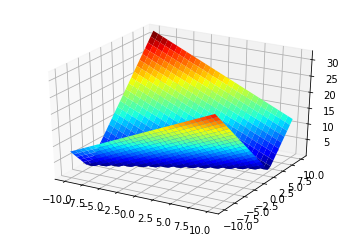

In [8]:
%matplotlib inline 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = calculate_distance(x, y)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)


The optimal values, i.e. those that make the if-condition true, have fitness value 0 and can be clearly seen at the bottom of the plot. The further away from the optimal values, the higher elevated the points in the search space.

### Instrumentation

The fitness function should calculate the distance value for concrete test executions. That is, we want to run the program, and then learn the distance value of this execution. However, the branching condition is hidden within the source code of the target function, and its value may in principle be the result of various calculations along the execution path reaching it. Even though in our example the condition is an equation using the input values of the function directly, this may not be the case in general; it might as well be derived values. Thus, the values we need to calculate our distance metric need to be observed directly at the conditional statement.

This is typically done with *instrumentation*: We add new code immediately before or after the branching condition to keep track of the values observed and calculate the distance using these values. The following is an instrumented version of our program under test, which prints out the distance values as it is executed:

In [9]:
def test_me_instrumented(x, y):
    
    print("Instrumentation: Input = (%d, %d), distance = %d" % (x, y, calculate_distance(x,y)))
    if x == 2*(y+1):
        return True 
    else:
        return False

Let's try this out for a couple of example values:

In [10]:
test_me_instrumented(0, 0)
test_me_instrumented(5, 2)
test_me_instrumented(22, 10)

Instrumentation: Input = (0, 0), distance = 2
Instrumentation: Input = (5, 2), distance = 1
Instrumentation: Input = (22, 10), distance = 0


True

When calculating a fitness value, we will execute the instrumented program version, but we need some means to access the distance value calculated during that execution. As a simple first solution to this problem, we can simply add a global variable and store the value of the distance calculation there. 

In [11]:
distance = 0
def test_me_instrumented(x, y):
    global distance
    distance = calculate_distance(x, y)
    if x == 2*(y+1):
        return True 
    else:
        return False

Using this instrumented version of `test_me`, we can now finally define our fitness function, which simply runs the instrumented `test_me_instrumented` function, and then retrieves the value of the global `distance` variable:

In [12]:
def get_fitness(x, y):
    global distance
    test_me_instrumented(x, y)
    fitness = distance
    return fitness

Let's try this on some example inputs:

In [13]:
print("Fitness of (0, 0)  = %d" % get_fitness(0, 0))
print("Fitness of (1, 2)  = %d" % get_fitness(1, 2))
print("Fitness of (22,10) = %d" % get_fitness(22,10))

Fitness of (0, 0)  = 2
Fitness of (1, 2)  = 5
Fitness of (22,10) = 0


### Hillclimbing the example

Having decided on a representation (2-tuples of integers) and a fitness function (distance to target branch), we can now finally go ahead and implement our search algorithm. Let's explore this search space using the simplest possible meta-heuristic algorithm: Hillclimbing. The metaphor captures aptly what is happening: The algorithm tries to climb a hill in the search space defined by our representation. Except, that in our search landscape the best values are not those high up but down low, so technically we are are descending into valleys.

The hillclimbing algorithm itself is very simple: 
1. Take a random starting point
2. Determine fitness value of all neighbours
3. Move to neighbour with the best fitness value
4. If solution is not found, continue with step 2

The hillclimber starts with a random test input, i.e., random values for `x` and `y`. For any pair of random integer numbers, the chances of them satisfying the condition `x == 2 * (y + 1)` are rather slim. Suppose the random values are `(274, 153)`. The right hand side of the equation, `2 * (y + 1)`, evaluates to 308, so the condition is clearly false. Where should the hillclimber go to now? Let's look at the fitness values of this test input and its neighbours:

In [14]:
x, y = 274, 153
print("%d, %d: %d" % (x, y, get_fitness(x, y)))
for nx, ny in neighbours(x, y):
    print("%d, %d: %d" % (nx, ny, get_fitness(nx, ny)))

274, 153: 34
273, 152: 33
273, 153: 35
273, 154: 37
274, 152: 32
274, 154: 36
275, 152: 31
275, 153: 33
275, 154: 35


Increasing `y` by one increases the value of the right hand side of the equation to `310`. Thus, the value on the left hand side of the equation thus differs *even more* to the value on the right hand side of the equation than it did before the increase! So, increasing `y` does not seem like a good idea. On the other hand, increasing `x` by one improves things: The left hand side and the right hand side of the equation become more similar; they are "less unequal". Thus, out of the eight possible neighbors of `(274, 153)`, the neighbor that increases `x` and decreases `y` (`(275, 152)`) seems best intuitively --- the outcome of the condition is still false, but it is "less so" than for the original value.

Let's now implement the hillcimbing algorithm. 

In [15]:
import random

def hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                print("New value: %d, %d at fitness %.4f" %(x, y, fitness))
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    
hillclimber()

Initial value: -2256, -7455 at fitness 12652.0000
New value: -2257, -7455 at fitness 12651.0000
New value: -2258, -7455 at fitness 12650.0000
New value: -2259, -7455 at fitness 12649.0000
New value: -2260, -7455 at fitness 12648.0000
New value: -2261, -7455 at fitness 12647.0000
New value: -2262, -7455 at fitness 12646.0000
New value: -2263, -7455 at fitness 12645.0000
New value: -2264, -7455 at fitness 12644.0000
New value: -2265, -7455 at fitness 12643.0000
New value: -2266, -7455 at fitness 12642.0000
New value: -2267, -7455 at fitness 12641.0000
New value: -2268, -7455 at fitness 12640.0000
New value: -2269, -7455 at fitness 12639.0000
New value: -2270, -7455 at fitness 12638.0000
New value: -2271, -7455 at fitness 12637.0000
New value: -2272, -7455 at fitness 12636.0000
New value: -2273, -7455 at fitness 12635.0000
New value: -2274, -7455 at fitness 12634.0000
New value: -2275, -7455 at fitness 12633.0000
New value: -2276, -7455 at fitness 12632.0000
New value: -2277, -7455 at fit

New value: -3455, -7455 at fitness 11453.0000
New value: -3456, -7455 at fitness 11452.0000
New value: -3457, -7455 at fitness 11451.0000
New value: -3458, -7455 at fitness 11450.0000
New value: -3459, -7455 at fitness 11449.0000
New value: -3460, -7455 at fitness 11448.0000
New value: -3461, -7455 at fitness 11447.0000
New value: -3462, -7455 at fitness 11446.0000
New value: -3463, -7455 at fitness 11445.0000
New value: -3464, -7455 at fitness 11444.0000
New value: -3465, -7455 at fitness 11443.0000
New value: -3466, -7455 at fitness 11442.0000
New value: -3467, -7455 at fitness 11441.0000
New value: -3468, -7455 at fitness 11440.0000
New value: -3469, -7455 at fitness 11439.0000
New value: -3470, -7455 at fitness 11438.0000
New value: -3471, -7455 at fitness 11437.0000
New value: -3472, -7455 at fitness 11436.0000
New value: -3473, -7455 at fitness 11435.0000
New value: -3474, -7455 at fitness 11434.0000
New value: -3475, -7455 at fitness 11433.0000
New value: -3476, -7455 at fitness

New value: -4465, -7455 at fitness 10443.0000
New value: -4466, -7455 at fitness 10442.0000
New value: -4467, -7455 at fitness 10441.0000
New value: -4468, -7455 at fitness 10440.0000
New value: -4469, -7455 at fitness 10439.0000
New value: -4470, -7455 at fitness 10438.0000
New value: -4471, -7455 at fitness 10437.0000
New value: -4472, -7455 at fitness 10436.0000
New value: -4473, -7455 at fitness 10435.0000
New value: -4474, -7455 at fitness 10434.0000
New value: -4475, -7455 at fitness 10433.0000
New value: -4476, -7455 at fitness 10432.0000
New value: -4477, -7455 at fitness 10431.0000
New value: -4478, -7455 at fitness 10430.0000
New value: -4479, -7455 at fitness 10429.0000
New value: -4480, -7455 at fitness 10428.0000
New value: -4481, -7455 at fitness 10427.0000
New value: -4482, -7455 at fitness 10426.0000
New value: -4483, -7455 at fitness 10425.0000
New value: -4484, -7455 at fitness 10424.0000
New value: -4485, -7455 at fitness 10423.0000
New value: -4486, -7455 at fitness

New value: -5632, -7455 at fitness 9276.0000
New value: -5633, -7455 at fitness 9275.0000
New value: -5634, -7455 at fitness 9274.0000
New value: -5635, -7455 at fitness 9273.0000
New value: -5636, -7455 at fitness 9272.0000
New value: -5637, -7455 at fitness 9271.0000
New value: -5638, -7455 at fitness 9270.0000
New value: -5639, -7455 at fitness 9269.0000
New value: -5640, -7455 at fitness 9268.0000
New value: -5641, -7455 at fitness 9267.0000
New value: -5642, -7455 at fitness 9266.0000
New value: -5643, -7455 at fitness 9265.0000
New value: -5644, -7455 at fitness 9264.0000
New value: -5645, -7455 at fitness 9263.0000
New value: -5646, -7455 at fitness 9262.0000
New value: -5647, -7455 at fitness 9261.0000
New value: -5648, -7455 at fitness 9260.0000
New value: -5649, -7455 at fitness 9259.0000
New value: -5650, -7455 at fitness 9258.0000
New value: -5651, -7455 at fitness 9257.0000
New value: -5652, -7455 at fitness 9256.0000
New value: -5653, -7455 at fitness 9255.0000
New value:

New value: -7058, -7455 at fitness 7850.0000
New value: -7059, -7455 at fitness 7849.0000
New value: -7060, -7455 at fitness 7848.0000
New value: -7061, -7455 at fitness 7847.0000
New value: -7062, -7455 at fitness 7846.0000
New value: -7063, -7455 at fitness 7845.0000
New value: -7064, -7455 at fitness 7844.0000
New value: -7065, -7455 at fitness 7843.0000
New value: -7066, -7455 at fitness 7842.0000
New value: -7067, -7455 at fitness 7841.0000
New value: -7068, -7455 at fitness 7840.0000
New value: -7069, -7455 at fitness 7839.0000
New value: -7070, -7455 at fitness 7838.0000
New value: -7071, -7455 at fitness 7837.0000
New value: -7072, -7455 at fitness 7836.0000
New value: -7073, -7455 at fitness 7835.0000
New value: -7074, -7455 at fitness 7834.0000
New value: -7075, -7455 at fitness 7833.0000
New value: -7076, -7455 at fitness 7832.0000
New value: -7077, -7455 at fitness 7831.0000
New value: -7078, -7455 at fitness 7830.0000
New value: -7079, -7455 at fitness 7829.0000
New value:

New value: -8131, -7455 at fitness 6777.0000
New value: -8132, -7455 at fitness 6776.0000
New value: -8133, -7455 at fitness 6775.0000
New value: -8134, -7455 at fitness 6774.0000
New value: -8135, -7455 at fitness 6773.0000
New value: -8136, -7455 at fitness 6772.0000
New value: -8137, -7455 at fitness 6771.0000
New value: -8138, -7455 at fitness 6770.0000
New value: -8139, -7455 at fitness 6769.0000
New value: -8140, -7455 at fitness 6768.0000
New value: -8141, -7455 at fitness 6767.0000
New value: -8142, -7455 at fitness 6766.0000
New value: -8143, -7455 at fitness 6765.0000
New value: -8144, -7455 at fitness 6764.0000
New value: -8145, -7455 at fitness 6763.0000
New value: -8146, -7455 at fitness 6762.0000
New value: -8147, -7455 at fitness 6761.0000
New value: -8148, -7455 at fitness 6760.0000
New value: -8149, -7455 at fitness 6759.0000
New value: -8150, -7455 at fitness 6758.0000
New value: -8151, -7455 at fitness 6757.0000
New value: -8152, -7455 at fitness 6756.0000
New value:

New value: -9631, -7455 at fitness 5277.0000
New value: -9632, -7455 at fitness 5276.0000
New value: -9633, -7455 at fitness 5275.0000
New value: -9634, -7455 at fitness 5274.0000
New value: -9635, -7455 at fitness 5273.0000
New value: -9636, -7455 at fitness 5272.0000
New value: -9637, -7455 at fitness 5271.0000
New value: -9638, -7455 at fitness 5270.0000
New value: -9639, -7455 at fitness 5269.0000
New value: -9640, -7455 at fitness 5268.0000
New value: -9641, -7455 at fitness 5267.0000
New value: -9642, -7455 at fitness 5266.0000
New value: -9643, -7455 at fitness 5265.0000
New value: -9644, -7455 at fitness 5264.0000
New value: -9645, -7455 at fitness 5263.0000
New value: -9646, -7455 at fitness 5262.0000
New value: -9647, -7455 at fitness 5261.0000
New value: -9648, -7455 at fitness 5260.0000
New value: -9649, -7455 at fitness 5259.0000
New value: -9650, -7455 at fitness 5258.0000
New value: -9651, -7455 at fitness 5257.0000
New value: -9652, -7455 at fitness 5256.0000
New value:

New value: -10000, -6325 at fitness 2648.0000
New value: -10000, -6324 at fitness 2646.0000
New value: -10000, -6323 at fitness 2644.0000
New value: -10000, -6322 at fitness 2642.0000
New value: -10000, -6321 at fitness 2640.0000
New value: -10000, -6320 at fitness 2638.0000
New value: -10000, -6319 at fitness 2636.0000
New value: -10000, -6318 at fitness 2634.0000
New value: -10000, -6317 at fitness 2632.0000
New value: -10000, -6316 at fitness 2630.0000
New value: -10000, -6315 at fitness 2628.0000
New value: -10000, -6314 at fitness 2626.0000
New value: -10000, -6313 at fitness 2624.0000
New value: -10000, -6312 at fitness 2622.0000
New value: -10000, -6311 at fitness 2620.0000
New value: -10000, -6310 at fitness 2618.0000
New value: -10000, -6309 at fitness 2616.0000
New value: -10000, -6308 at fitness 2614.0000
New value: -10000, -6307 at fitness 2612.0000
New value: -10000, -6306 at fitness 2610.0000
New value: -10000, -6305 at fitness 2608.0000
New value: -10000, -6304 at fitnes

The hillclimber starts by choosing random values for `x` and `y`. We use low values in the range of `0`--`1000` to reduce the time search takes when playing with the example. Then, we determine the fitness value of this starting point by calling `get_fitness`. Recall that we are trying to find the smallest possible fitness value, therefore we now loop until we have either found a fitness value of `0` (i.e., an optimal value). 

In this loop, we iterate over all neighbours (`neighbours`), and evaluate the fitness value of each of the neighbours. As soon as we have found a neighbour with better (smaller) fitness, the hillclimber exits the loop and uses this as the new starting point. An alternative variant of this simple hillclimbing algorithm would be to remove the `break` statement: By doing so, *all* neighbours would be evaluated and the best neighbour would be chosen. This is known as *steepest ascent hillclimbing*, and it is a trivial change: We simply need to remove the `break` and continue evaluating neighbours. You will see that the number of iterations necessary to reach the optimum is lower, although for each iteration more tests are executed.

In [16]:
def steepest_ascent_hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                print("New value: %d, %d at fitness %.4f" %(x, y, fitness))

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    
steepest_ascent_hillclimber()

Initial value: -6430, -9017 at fitness 11602.0000
New value: -6431, -9017 at fitness 11601.0000
New value: -6431, -9016 at fitness 11599.0000
New value: -6432, -9016 at fitness 11598.0000
New value: -6432, -9015 at fitness 11596.0000
New value: -6433, -9015 at fitness 11595.0000
New value: -6433, -9014 at fitness 11593.0000
New value: -6434, -9014 at fitness 11592.0000
New value: -6434, -9013 at fitness 11590.0000
New value: -6435, -9013 at fitness 11589.0000
New value: -6435, -9012 at fitness 11587.0000
New value: -6436, -9012 at fitness 11586.0000
New value: -6436, -9011 at fitness 11584.0000
New value: -6437, -9011 at fitness 11583.0000
New value: -6437, -9010 at fitness 11581.0000
New value: -6438, -9010 at fitness 11580.0000
New value: -6438, -9009 at fitness 11578.0000
New value: -6439, -9009 at fitness 11577.0000
New value: -6439, -9008 at fitness 11575.0000
New value: -6440, -9008 at fitness 11574.0000
New value: -6440, -9007 at fitness 11572.0000
New value: -6441, -9007 at fit

New value: -6962, -8486 at fitness 10008.0000
New value: -6962, -8485 at fitness 10006.0000
New value: -6963, -8485 at fitness 10005.0000
New value: -6963, -8484 at fitness 10003.0000
New value: -6964, -8484 at fitness 10002.0000
New value: -6964, -8483 at fitness 10000.0000
New value: -6965, -8483 at fitness 9999.0000
New value: -6965, -8482 at fitness 9997.0000
New value: -6966, -8482 at fitness 9996.0000
New value: -6966, -8481 at fitness 9994.0000
New value: -6967, -8481 at fitness 9993.0000
New value: -6967, -8480 at fitness 9991.0000
New value: -6968, -8480 at fitness 9990.0000
New value: -6968, -8479 at fitness 9988.0000
New value: -6969, -8479 at fitness 9987.0000
New value: -6969, -8478 at fitness 9985.0000
New value: -6970, -8478 at fitness 9984.0000
New value: -6970, -8477 at fitness 9982.0000
New value: -6971, -8477 at fitness 9981.0000
New value: -6971, -8476 at fitness 9979.0000
New value: -6972, -8476 at fitness 9978.0000
New value: -6972, -8475 at fitness 9976.0000
New 

New value: -7630, -7817 at fitness 8002.0000
New value: -7631, -7817 at fitness 8001.0000
New value: -7631, -7816 at fitness 7999.0000
New value: -7632, -7816 at fitness 7998.0000
New value: -7632, -7815 at fitness 7996.0000
New value: -7633, -7815 at fitness 7995.0000
New value: -7633, -7814 at fitness 7993.0000
New value: -7634, -7814 at fitness 7992.0000
New value: -7634, -7813 at fitness 7990.0000
New value: -7635, -7813 at fitness 7989.0000
New value: -7635, -7812 at fitness 7987.0000
New value: -7636, -7812 at fitness 7986.0000
New value: -7636, -7811 at fitness 7984.0000
New value: -7637, -7811 at fitness 7983.0000
New value: -7637, -7810 at fitness 7981.0000
New value: -7638, -7810 at fitness 7980.0000
New value: -7638, -7809 at fitness 7978.0000
New value: -7639, -7809 at fitness 7977.0000
New value: -7639, -7808 at fitness 7975.0000
New value: -7640, -7808 at fitness 7974.0000
New value: -7640, -7807 at fitness 7972.0000
New value: -7641, -7807 at fitness 7971.0000
New value:

New value: -8211, -7236 at fitness 6259.0000
New value: -8212, -7236 at fitness 6258.0000
New value: -8212, -7235 at fitness 6256.0000
New value: -8213, -7235 at fitness 6255.0000
New value: -8213, -7234 at fitness 6253.0000
New value: -8214, -7234 at fitness 6252.0000
New value: -8214, -7233 at fitness 6250.0000
New value: -8215, -7233 at fitness 6249.0000
New value: -8215, -7232 at fitness 6247.0000
New value: -8216, -7232 at fitness 6246.0000
New value: -8216, -7231 at fitness 6244.0000
New value: -8217, -7231 at fitness 6243.0000
New value: -8217, -7230 at fitness 6241.0000
New value: -8218, -7230 at fitness 6240.0000
New value: -8218, -7229 at fitness 6238.0000
New value: -8219, -7229 at fitness 6237.0000
New value: -8219, -7228 at fitness 6235.0000
New value: -8220, -7228 at fitness 6234.0000
New value: -8220, -7227 at fitness 6232.0000
New value: -8221, -7227 at fitness 6231.0000
New value: -8221, -7226 at fitness 6229.0000
New value: -8222, -7226 at fitness 6228.0000
New value:

New value: -8961, -6487 at fitness 4011.0000
New value: -8961, -6486 at fitness 4009.0000
New value: -8962, -6486 at fitness 4008.0000
New value: -8962, -6485 at fitness 4006.0000
New value: -8963, -6485 at fitness 4005.0000
New value: -8963, -6484 at fitness 4003.0000
New value: -8964, -6484 at fitness 4002.0000
New value: -8964, -6483 at fitness 4000.0000
New value: -8965, -6483 at fitness 3999.0000
New value: -8965, -6482 at fitness 3997.0000
New value: -8966, -6482 at fitness 3996.0000
New value: -8966, -6481 at fitness 3994.0000
New value: -8967, -6481 at fitness 3993.0000
New value: -8967, -6480 at fitness 3991.0000
New value: -8968, -6480 at fitness 3990.0000
New value: -8968, -6479 at fitness 3988.0000
New value: -8969, -6479 at fitness 3987.0000
New value: -8969, -6478 at fitness 3985.0000
New value: -8970, -6478 at fitness 3984.0000
New value: -8970, -6477 at fitness 3982.0000
New value: -8971, -6477 at fitness 3981.0000
New value: -8971, -6476 at fitness 3979.0000
New value:

New value: -9643, -5805 at fitness 1965.0000
New value: -9643, -5804 at fitness 1963.0000
New value: -9644, -5804 at fitness 1962.0000
New value: -9644, -5803 at fitness 1960.0000
New value: -9645, -5803 at fitness 1959.0000
New value: -9645, -5802 at fitness 1957.0000
New value: -9646, -5802 at fitness 1956.0000
New value: -9646, -5801 at fitness 1954.0000
New value: -9647, -5801 at fitness 1953.0000
New value: -9647, -5800 at fitness 1951.0000
New value: -9648, -5800 at fitness 1950.0000
New value: -9648, -5799 at fitness 1948.0000
New value: -9649, -5799 at fitness 1947.0000
New value: -9649, -5798 at fitness 1945.0000
New value: -9650, -5798 at fitness 1944.0000
New value: -9650, -5797 at fitness 1942.0000
New value: -9651, -5797 at fitness 1941.0000
New value: -9651, -5796 at fitness 1939.0000
New value: -9652, -5796 at fitness 1938.0000
New value: -9652, -5795 at fitness 1936.0000
New value: -9653, -5795 at fitness 1935.0000
New value: -9653, -5794 at fitness 1933.0000
New value:

New value: -10000, -5072 at fitness 142.0000
New value: -10000, -5071 at fitness 140.0000
New value: -10000, -5070 at fitness 138.0000
New value: -10000, -5069 at fitness 136.0000
New value: -10000, -5068 at fitness 134.0000
New value: -10000, -5067 at fitness 132.0000
New value: -10000, -5066 at fitness 130.0000
New value: -10000, -5065 at fitness 128.0000
New value: -10000, -5064 at fitness 126.0000
New value: -10000, -5063 at fitness 124.0000
New value: -10000, -5062 at fitness 122.0000
New value: -10000, -5061 at fitness 120.0000
New value: -10000, -5060 at fitness 118.0000
New value: -10000, -5059 at fitness 116.0000
New value: -10000, -5058 at fitness 114.0000
New value: -10000, -5057 at fitness 112.0000
New value: -10000, -5056 at fitness 110.0000
New value: -10000, -5055 at fitness 108.0000
New value: -10000, -5054 at fitness 106.0000
New value: -10000, -5053 at fitness 104.0000
New value: -10000, -5052 at fitness 102.0000
New value: -10000, -5051 at fitness 100.0000
New value:

Our example program has a very nice fitness landscape --- there is a perfect gradient, and the hillclimber will always find a solution. We can see this nice gradient if we plot the fitness values observed over time:

Found optimum after 1189 iterations at -1000, -501


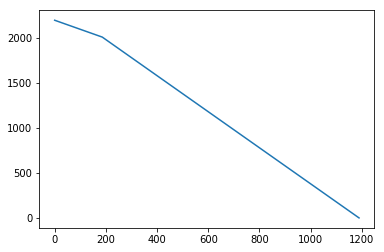

In [17]:
MAX=1000
MIN=-MAX

def plotting_hillclimber(fitness_function):
    data = []
    
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = fitness_function(x, y)
    data += [fitness]
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = fitness_function(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                data += [fitness]
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    return data
    
data = plotting_hillclimber(get_fitness)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

x = range(len(data))
ax.plot(x, data);


This is gradient is the result of an ideal fitness landscape. In practice, we won't always have such a nice gradient. In particular, our hillclimber only works well as long as there is at least one neighbour that has a better fitness value. What if we reach a point where _none_ of the neighbours actually has a better fitness value? Consider the following variant of our example `test_me` program:

In [18]:
def test_me2(x, y):
    if x == 2*(y+1):
        return True 
    else:
        return False   

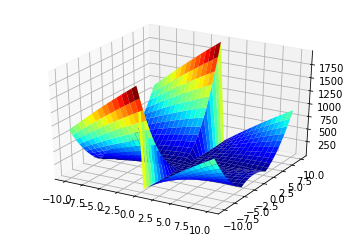

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from math import exp, tan

x = np.outer(np.linspace(-10, 10, 30), np.ones(30))
y = x.copy().T
z = abs(x*x - y*y * (x % 20))
    

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)


Suppose we have this kind of fitness landscape. We will just use a simulated fitness function for this:

In [20]:
def bad_fitness(x, y):
    # Simulated bad fitness landscape
    fitness = abs(x*x - y*y * (x % 20))
    return fitness

Running our hillclimber with this fitness function is not a good idea, because it might never terminate. Suppose we've reached a point where all neighbours have the same or a worse fitness value. The hillclimber can move no where and is stuck there forever! Such a point in the search landscape is called a *local optimum*. If one reaches such a point, the easiest way out is to give up and restart from a new random point. This is what we will do in our hillclimber with *random restarts*. 

In [21]:
def restarting_hillclimber(fitness_function):
    data = []
    
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = fitness_function(x, y)
    data += [fitness]
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        changed = False
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = fitness_function(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                data += [fitness]
                changed = True
                break
        if not changed:
            x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
            fitness = fitness_function(x, y)
            data += [fitness]

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    return data

The change is trivial: We simply keep track whether any movement has occurred with a boolean flag, and if we did not move to any of the neighbours, we pick a new random starting position. We also made the hillclimber parameterizable with fitness functions. Let's try it out with our `bad_fitness` and plot the resulting fitness values we observe:

Initial value: 158, 835 at fitness 12525086.0000
Found optimum after 439 iterations at -959, 959


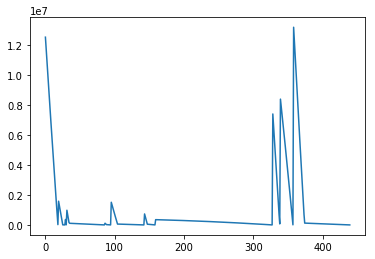

In [22]:
MAX=1000
MIN=-MAX

data = restarting_hillclimber(bad_fitness)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

x = range(len(data))
ax.plot(x, data);


Run the example a couple of times. Sometimes, we are lucky and there is a gradient that takes is straight to an optimal solution. But sometimes you'll see restarts throughout the search before reaching an optimal value.

We restricted initial values of `x` and `y` to  rather small range of `[MIN, MAX]`. This is a common trick in test generation, as in *most* cases solutions tend to consist of small values, and using small values to start the search makes the search quicker in many cases. However, what if the solution we need is at a completely different place in our search space? Our bias towards smaller solutions would mean that the hillclimber would take very long to find the solution, and given a fixed search budget it would thus be less likely to actually find a solution. To see what effects this would have, we could simple replace the `1000` with, say, `1000000` or more. We can play around with the range to see the performance we get for our simple search problems.

In [23]:
MAX =  100000
MIN = -MAX

import time
start = time.process_time()
restarting_hillclimber(get_fitness)
duration = time.process_time() - start
print("Search time: %.2fs" % duration)

Initial value: -89186, -33095 at fitness 22998.0000
Found optimum after 16906 iterations at -100000, -50001
Search time: 0.14s


 In most cases the search now will take extremely long until a solution is found --- much longer than we are prepared to wait for such a simple example function! How is this ever going to work on "real" examples? Not to imagine if there were even more parameters!

## Testing a More Complex Program

Let's turn to a slightly more complex program: The CGI decoder you already know from chapter TODO. 

In [24]:
def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""

    # Mapping of hex digits to their integer values
    hex_values = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15,
        'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15,
    }

    t = ""
    i = 0
    while i < len(s):
        c = s[i]
        if c == '+':
            t += ' '
        elif c == '%':
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if digit_high in hex_values and digit_low in hex_values:
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
                raise ValueError("Invalid encoding")
        else:
            t += c
        i += 1
    return t


### CGI Decoder as a Search Problem

The `cgi_decode` function has one input of type string, and one possible way to define the neighbourhood of a string is by all possible strings that have an edit distance of 1. For example, string `test` would have two neighbours for each character:

- `uest`
- `tfst`
- `tett`
- `tesu`
- `sest`
- `tdst`
- `tert`
- `tess`

In addition, prepending any character or appending any character would also have an edit distance of 1 and could be considered neighbours. To keep things simple, let's keep the length of our input strings fixed to a reasonable value (e.g. 10). In this case, each individual has 20 neighbours (i.e., each character has two neighbours).

Let's implement a new `neighbours` function that produces these neighbouring strings:

In [25]:
def neighbour_strings(x):
    n = []
    for pos in range(len(x)):
      c = ord(x[pos])
      if c < 127:
        n += [ x[:pos] + chr(c + 1) + x[pos + 1:] ]
      if c > 20:
        n += [ x[:pos] + chr(c - 1) + x[pos + 1:] ]
    return n

The `neighbour_strings` function gets the numerical value of each character in the input string, and creates a new string with the character replaced with the preceding and succeeding characters in the alphabet. To start with, we only consider printable ASCII characters, which are in the range 20--127.

In [26]:
print(neighbour_strings("Hello"))

['Iello', 'Gello', 'Hfllo', 'Hdllo', 'Hemlo', 'Heklo', 'Helmo', 'Helko', 'Hellp', 'Helln']


Thus we have defined the search space for the `cgi_decode` function. The next ingredient to searching for individuals in this search space is a fitness function.

### Branch Distances

The `test_me` function consisted of a single if-condition, in which two integer numbers were compared. In the `cgi_decode` function we have three if-conditions and one while loop, and they all compare characters. Fortunately, as we have already seen, we can treat characters like numbers, so we can use the same distance estimate we used in the `test_me` example. However, there are also two conditions which check whether a character is contained in a set, e.g. `digit_high in hex_values`. How close is a value to being contained in the set? An obvious solution would be to consider the distance to the closes value in the set as the estimate.

In [27]:
import sys

def distance_character(target, values):
    minimum = sys.maxsize
    for elem in values:
        distance = abs(target - elem)
        if distance < minimum:
            minimum = distance
    return minimum

print(distance_character(10, [1, 5, 12, 100]))
print(distance_character(10, [0, 50, 80, 200]))


2
10


A further simplification we have made so far was to assume that we would always want conditions to evaluate to true. In practice, we might want to have if-conditions evaluate to false just as well. Thus, each if-condition actually has two distance estimates, one to estimate how close it is to being true, and one how close it is to being false. If the condition is true, then the true distance is 0; if the condition is false, then the false distance is 0. That is, in a comparison `a == b`, if `a` is smaller than `b`, then the false distance of is `0` by definition. 

What is the distance of `a == b` being false when `a` equals `b`? Any change to either `a` or `b` would make the condition evaluate to false, so we can define the distance simply as 1.

More generally, there can be other types of comparisons, for example using relational operators. Consider the loop condition in `cgi_decode`: `i < len(s)`, i.e., it uses a less-than comparison operator. It is quite straight forward to extend our notion of branch distance to cover different types of comparisons, and to calculate true and false distances.  The following table shows how to calculate the distance for different types of comparisons:

| Condition | Distance True | Distance False |
| ------------- |:-------------:| -----:|
| a == b      | abs(a - b) | 1 |
| a != b      | 1          | abs(a - b) |
| a < b       | b - a + 1  | a - b      |
| a <= b      | b - a      | a - b + 1  |
| a > b       | a - b + 1  | b - a      |


Note that several of the calculations add a constant `1`. The reason for this is quite simple: Suppose we want to have `a < b` evaluate to true, and let `a = 27` and `b = 27`. The condition is not true, but simply taking the difference would give us a result of `0`. To avoid this, we have to add a constant value. It is not important whether this value is `1` -- any positive constant works.

### Dealing with Complex Conditions

In the `cgi_decode` function, we can also find a somewhat more complex predicate which consists of several comparisons:

`
if digit_high in hex_values and digit_low in hex_values:
`

In principle, the branch distance is defined such that the distance to make a conjunction `A and B` true equals the sum of the branch distances for `A` and `B`, as both of the two conditions would need to be true. Similarly, the branch distance to make `A or B` true would be the minimum of the two branch distances of `A` and `B`, as it suffices if one of the two conditions is true to make the entire expression true. 

However, it is not as easy as that in practice: Predicates can consist of nested conditions and negations, and one would need to convert the expression to canonical form before being able to apply this calculation. Furthermore, most modern programming languages use *short-circuit evaluation*: If there is a condition `A or B`, and `A` is true, then `B` is never evaluated. If `B` is an expression with side-effects, then by calculating the branch distance of `B` even though short-circuit evaluation would avoid its execution, we would potentially be changing the program behavior (by invoking the side-effect that would in normal behavior not be executed), and that is not acceptable.


Furthermore, what if the branching condition has side-effects? For example, suppose that the branching condition were `x == 2 * foo(y)`, where `foo` is a function that takes an integer as input. Naively instrumenting would lead to the following code:

```
    distance = abs(x - 2 * foo(y))
	if x == 2 * foo(y):
	...
```

Thus, the instrumentation would lead to `foo` being executed *twice*. Suppose `foo` changes the state of the system (e.g., by printing something, accessing the filesystem, changing some state variables, etc.), then clearly invoking `foo` a second time is a bad idea. One way to overcome this problem is to transform the conditions, rather than adding tracing calls. For example, one can create temporary variables that hold the values necessary for the distance calculation and then use these in the branching condition:

```
	tmp1 = x
	tmp2 = 2 * foo(y)
	distance = abs(tmp1, tmp2)
	if tmp1 == tmp2:
	...
```

Besides these issues, the approach of adding a global variable and method call to the program seems like a rather clumsy approach --- surely we cannot start thinking about every branch in our program on its own and instrument the program we want to test manually, in particular if programs have multiple branches like the `cgi_decode` function. Rather, we should be looking at how to _automatically_ instrument programs to contain the necessary added statements such that we can calculate fitness values.

### Instrumentation for atomic conditions

An alternative approach to using the global and temporary variables is to replace the actual comparison with a call to a helper function, where the original expressions are evaluated as arguments, and the operator is an additional argument. Assume a `evaluate_condition` function which takes four parameters: `num` is a unique id that identifies the condition; `op` is the operator of the comparison; `lhs` and `rhs` are the operands. The function calculates two distances for the condition: The distance to the condition evaluating to true, and the distance to the condition evaluating to false. One of the two outcomes will always be true, and thus one of them will always have distance `0`. The function returns true or false, depending on which distance is `0`. That means, the example expression 

```
    if x == 2 * foo(y)
```
    
would be replaced by 

```
    if evaluate_condition(0, "==", x, 2 * foo(y))
```

such that the arguments are only evaluated once, and side-effects are thus handled correctly. Here is how the `evaluate_condition` function looks like:

TODO: Explain global map instead of global variable
TODO: Point out that `BranchPredicate` needs to return true or false


In [28]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true  = 0
    distance_false = 0
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    # ... code for other types of conditions
    
    if distance_true == 0:
        return True
    else:
        return False

Note that we are initializing `distance_true` and `distance_false` with `0`. Thus, if `lhs` equals `rhs`, then the variable `distance_true` remains 0, and vice versa.

In [29]:
evaluate_condition(1, "Eq", 10, 20)

False

In [30]:
evaluate_condition(2, "Eq", 20, 20)

True

What the `evaluate_condition` function does not do yet is store the distances observed. Obviously, we will need to store the values somewhere so that we can access it from our fitness function. Since the `cgi_decode` program consists of several conditions, and for each condition we might be interested in the true and the false distance, we simply use two global dictionaries, `distances_true` and `distances_false`:

In [31]:
def update_maps(num, d_true, d_false):
    global distances_true, distances_false
    
    if num in distances_true.keys():
        distances_true[num]  = min(distances_true[num], d_true)
    else:
        distances_true[num]  = d_true

    if num in distances_false.keys():
        distances_false[num] = min(distances_false[num], d_false)
    else:
        distances_false[num] = d_false


We simply need to call this function from within `evaluate_condition`. Let's also add the calculation of distance for the `in` operator and the `<` comparison. Furthermore, `cgi_decode` actually compares characters and numbers. To make sure we use the correct types, we first have to convert the characters to numbers to calculate the distances. This is done using Python's `ord` function.

In [32]:
def evaluate_condition(num, op, lhs, rhs):
    distance_true  = 0
    distance_false = 0
    
    # Make sure the distance can be calculated on number and character comparisons
    if type(lhs) == str:
        lhs = ord(lhs)
    if type(rhs) == str:
        rhs = ord(rhs)
    
    if op == "Eq":
        if lhs == rhs:
            distance_false = 1
        else:
            distance_true = abs(lhs - rhs)

    elif op == "Lt":
        if lhs < rhs:
            distance_false = rhs - lhs
        else:
            distance_true  = lhs - rhs + 1
    # ...
    # handle other comparison operators
    # ...
    
    elif op == "In":
        minimum = sys.maxsize
        for elem in rhs.keys():
            distance = abs(lhs - ord(elem))
            if distance < minimum:
                minimum = distance

        distance_true = minimum
        if distance_true == 0:
            distance_false = 1

    update_maps(num, distance_true, distance_false)
            
    if distance_true == 0:
        return True
    else:
        return False

The following shows the instrumentation of the conjunction from `cgi_decode`. There are two calls to `evaluate_condition` corresponding to the two conditions, and the `and` with which they are conjoined ensures that the original short-circuiting behavior is preserved:

`
if (evaluate_condition(4, 'In', digit_high, hex_values) and evaluate_condition(5, 'In', digit_low, hex_values))
`

Of course we would like to automatically produce this instrumented varion.

TODO: Remainder of complex conditions. Exercise?

### Instrumenting source code automatically

Replacing comparisons automatically is quite easy on the abstract syntax tree (AST) of the program. In the AST, a comparison will typically be a tree node with an operator attribute and two children for the left-hand and right-hand operators. To replace such comparisons with a call to `evaluate_condition` one simply needs to replace the comparison node in the AST with a function call node, and this is what the `BranchDistanceTransformation` function does using a NodeTransformer:


In [33]:
import ast

class BranchTransformer(ast.NodeTransformer):

    branch_num = 0

    def visit_Compare(self, node):
        if node.ops[0] in [ast.Is, ast.IsNot, ast.In, ast.NotIn]:
            return node

        self.branch_num += 1
        return ast.Call(func = ast.Name("evaluate_condition", ast.Load()),
                        args = [ast.Num(self.branch_num),
                                ast.Str(node.ops[0].__class__.__name__),
                                node.left,
                                node.comparators[0]],
                        keywords=[],
                        starargs=None,
                        kwargs=None)

The `BranchDistanceTransformer` parses a target Python program using the built-in parser `ast.parse`, which returns the AST. Python provides API to traverse and modify this AST. To replace the comparison with a function call we use an `ast.NodeTransformer`, which uses the visitor pattern where there is one `visit_*` function for each type of node in the AST. As we are interested in replacing comparisons, we override `visit_Compare`, where instead of the original comparison node we return a new node of type `ast.Func`, which is a function call node. The first parameter of this node is the name of the function `evaluate_condition`), and the arguments are the four arguments that our `evaluate_condition` function expects: Number of branch (for which we keep a count in `branch_num`), the operator (for which we simply use the class name), the left-hand side, and the right-hand side. Note that Python allows comparisons of multiple expressions (e.g. `1 < x < 10`); to keep the code simple we only deal with individual comparisons here, but it would be straight forward to extend the code by treating each comparison with an individual call to `evaluate_condition`.


The following code parses the source code of the `cgi_decode` function to an AST, then transforms it, and prints it out again (using the `to_source` function from the `astor` library):

In [34]:
import inspect
import ast
from astor import to_source

source = inspect.getsource(cgi_decode)
node = ast.parse(source)
BranchTransformer().visit(node)

# Make sure the line numbers are ok before printing
node = ast.fix_missing_locations(node)
print(to_source(node))

def cgi_decode(s):
    """Decode the CGI-encoded string `s`:
       * replace "+" by " "
       * replace "%xx" by the character with hex number xx.
       Return the decoded string.  Raise `ValueError` for invalid inputs."""
    hex_values = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
        '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14,
        'f': 15, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15}
    t = ''
    i = 0
    while evaluate_condition(1, 'Lt', i, len(s)):
        c = s[i]
        if evaluate_condition(2, 'Eq', c, '+'):
            t += ' '
        elif evaluate_condition(3, 'Eq', c, '%'):
            digit_high, digit_low = s[i + 1], s[i + 2]
            i += 2
            if evaluate_condition(4, 'In', digit_high, hex_values
                ) and evaluate_condition(5, 'In', digit_low, hex_values):
                v = hex_values[digit_high] * 16 + hex_values[digit_low]
                t += chr(v)
            else:
             

To calculate a fitness value with the instrumented version, we need to compile the instrumented AST, and then create a new module

TODO: Can we use this to hook it into the current module? Then we wouldn't need the hack of copying evaluate_condition over:
```
import sys
current_module = sys.modules[__name__]
```

In [35]:
def get_instrumented_function(f):
    source = inspect.getsource(f)
    node = ast.parse(source)
    node = BranchTransformer().visit(node)

    # Make sure the line numbers are ok so that it compiles
    node = ast.fix_missing_locations(node)    

    # Create a new module in which to place the instrumented function
    import types
    module = types.ModuleType("cgi_decode_instrumented")
    code = compile(node, filename="<ast>", mode="exec")    
    exec(code, module.__dict__)
    
    # Add a reference to the instrumented function so we don't have to
    # deal with namespaces and imports
    module.evaluate_condition = evaluate_condition
    return module.cgi_decode
    
# Set up the global maps
distances_true = {}
distances_false = {}

# Create instrumented function
cgi_decode_instrumented = get_instrumented_function(cgi_decode)

# Outputs should be the same
print("Original    : %s" % cgi_decode("Hello+Reader"))
print("Instrumented: %s" % cgi_decode_instrumented("Hello+Reader"))

print(distances_true)
print(distances_false)

Original    : Hello Reader
Instrumented: Hello Reader
{1: 0, 2: 0, 3: 35}
{1: 0, 2: 0, 3: 0}


As we can see from the `distances_true` and `distances_false` maps, conditions 1 and 2 have evaluated to true and to false, whereas condition 3 has only evaluated to false. This is as expected, since the while-loop was entered and left, and there was one white space but no `%`-character in the input string.

### Fitness function to create valid hexadecimal inputs

As an example, let's take as objective to test the part of `cgi_decode` that decodes valid hexadecimal codes. This means that we want to make condition 1 true, 2 false, 3 true, and 4 true. To represent such a path, we can simply sum up the branch distances for exactly these branches. However, there is a potential issue with simply summing up branch distances: If the distance for one condition depends on a comparison of very large values and the distance calculation for another condition depends on small values, then an improvement of the large values would very likely lead to a better fitness improvement, and thus bias the search. To avoid this, we need to *normalize* branch distances before adding them up.

A normalisation function for a range `[a, b]` takes a number as input and returns a value that is `>=` and `<=`. The important thing about the function is that for any two numbers `x` and `y` the ordering needs to be preserved by the normalisation. That is, if `x<y` then it must also hold that `normalize(x) < normalize(y)`. There are many different functions that could achieve this result; a simple one is `normalize(x) = x/(x+k)`: It is computationally cheap, and will normalise any positive value in the range `[0,1]` (to change this to `[0,b]` one would just need to multiply by `b`). If we use this normalisation function, we know our `K` exactly: it is `1.0`. The function assumes that the value to be normalised is positive. The value of the factor `k` defines the steepness of the curve. For example, for `k=1` (which is a good default value) the curve is very steep, with values quickly approaching, but never reaching, `1`.

In [36]:
def normalize(x):
    return x/(1.0+x)

Using this normalization function, we can calculate a fitness value by running the instrumented program under test, and then adding up the normalized values of the relevant branches. However, not every if statement will be executed by every test case. What is the branch distance for a branch that wasn't even executed? We need to make sure that the branch distance for branches that weren't even executed is higher than any of the branch distances observed during execution. If we use normalization, then we know this maximum value is 1. Thus, the fitness function could look like this:

In [37]:
def get_fitness(x):
    global distances_true, distances_false
    distances_true = {}
    distances_false = {}
    try:
        cgi_decode_instrumented(x)
    except:
        pass
    fitness = 0.0
    for branch in [1,3,4,5]:
        if branch in distances_true:
            fitness += normalize(distances_true[branch])
        else:
            fitness += 1.0
                                 
    for branch in [2]:
        if branch in distances_false:
            fitness += normalize(distances_false[branch])
        else:
            fitness += 1.0
    
    return fitness

To see our instrumentation in action, let's calculate fitness values for a couple of example inputs, progressively getting closer to the target.

In [38]:
# Empty string does not even enter the loop
print(get_fitness(""))

# String contains no percentage character
print(get_fitness("Hello+Reader"))

# String contains a percentage character, but no valid hex char
print(get_fitness("%UU"))

# String contains a percentage character, but only one valid hex char
print(get_fitness("%AU"))

# String contains a percentage character and two valid hex chars
print(get_fitness("%AA"))

4.5
2.9722222222222223
1.9230769230769231
0.9230769230769231
0.0


### Hillclimbing valid hexadecimal inputs

We have now defined the search space through our `neighbour_strings` function, and we have derived a new fitness function, so before we can apply the hillclimber to the problem of finding strings that contain valid 2 digit hex codes, the only remaining point is to derive a random starting point, which you've already done previously in chapter TODO:

In [39]:
def random_string(l):
    s = ""
    for i in range(l):
        random_character = chr(random.randrange(32, 127))
        s = s + random_character
    return s

Now we can put it all together and use the identical hillclimbing algorithm again, and just make it generate random strings instead of numbers, and use the new fitness function:

In [40]:
def hillclimb_cgi():
    x = random_string(10)
    fitness = get_fitness(x)
    print("Initial input: %s at fitness %.4f" %(x, fitness))                

    while fitness > 0:
        changed = False
        for (nextx) in neighbour_strings(x):
            new_fitness = get_fitness(nextx)
            if new_fitness < fitness:
                x = nextx
                fitness = new_fitness
                changed = True
                print("New value: %s at fitness %.4f" %(x, fitness))                
                break

        # Random restart if necessary
        if not changed:
            x = random_string(10)
            fitness = get_fitness(x)

    print("Optimum at %s, fitness %.4f" % (x, fitness))
    
hillclimb_cgi()

Initial input: @\,Tb90w+f at fitness 2.8750
New value: @\,Tb90w*f at fitness 2.8333
New value: @\,Tb90w)f at fitness 2.8000
New value: @\,Tb90w(f at fitness 2.7500
New value: @\,Tb90w'f at fitness 2.6667
New value: @\,Tb90w&f at fitness 2.5000
New value: @\,Tb90w%f at fitness 2.0000
New value: mZ%%Tljtg= at fitness 1.9167
New value: mZ%&Tljtg= at fitness 1.9091
New value: mZ%'Tljtg= at fitness 1.9000
New value: mZ%(Tljtg= at fitness 1.8889
New value: mZ%)Tljtg= at fitness 1.8750
New value: mZ%*Tljtg= at fitness 1.8571
New value: mZ%+Tljtg= at fitness 1.8333
New value: mZ%,Tljtg= at fitness 1.8000
New value: mZ%-Tljtg= at fitness 1.7500
New value: mZ%.Tljtg= at fitness 1.6667
New value: mZ%/Tljtg= at fitness 1.5000
New value: mZ%0Tljtg= at fitness 0.9286
New value: mZ%0Uljtg= at fitness 0.9231
New value: mZ%0Vljtg= at fitness 0.9167
New value: mZ%0Wljtg= at fitness 0.9091
New value: mZ%0Xljtg= at fitness 0.9000
New value: mZ%0Yljtg= at fitness 0.8889
New value: mZ%0Zljtg= at fitness 0.8

Run the hillclimber a couple of times to see it generate strings with valid hex characters. Sometimes it only takes a couple of steps, sometimes it takes longer, but at the end it always solves the problem and generates the string we want to have.

TODO Exercises:
- Target different branch

## Evolutionary Search

Hillclimbing works well, if the neighbourhood is reasonably small. This was the case so far in the `cgi_decode` example because we limited ourselves to a fixed number of characters (10) and limited the character range to printable ASCII characters. But imagine what happens if we are not looking for ASCII characters, but  UTF-16 unicode characters? These are not allowed in URLs really, but let's see what happens if we change our search space:

In [42]:
def random_string(l):
    s = ""
    for i in range(l):
        # Limits to reflect range of UTF-16
        random_character = chr(random.randrange(0, 65536))
        s = s + random_character
    return s

def string_neighbours(x):
    n = []
    for pos in range(len(x)):
      c = ord(x[pos])
      # Limits to reflect range of UTF-16
      if c < 65536:
        n += [ x[:pos] + chr(c + 1) + x[pos + 1:] ]
      if c > 0:
        n += [ x[:pos] + chr(c - 1) + x[pos + 1:] ]

    return n

UTF-8 characters are represented with 16 bits, and this gives us a range of 65536 possible characters. The functions above are adapted to these boundaries. Before we run the hillclimber again, let's make one more change: We will add an iteration limit so that we can give up the search, rather than waiting forever for it to complete.

In [43]:
# This takes a loooooooong time
# You can either believe us, or try uncommenting it and wait.

def hillclimb_cgi_limited(max_iterations):
    x = random_string(10)
    fitness = get_fitness(x)
    print("Initial input: %s at fitness %.4f" %(x.encode('utf-8', 'replace').decode('utf-8'), fitness))                

    iteration = 0
    while fitness > 0 and iteration < max_iterations:
        changed = False
        for (nextx) in neighbour_strings(x):
            new_fitness = get_fitness(nextx)
            if new_fitness < fitness:
                x = nextx
                fitness = new_fitness
                changed = True
                print("New value: %s at fitness %.4f" %(x.encode('utf-8', 'replace').decode('utf-8'), fitness))                
                break

        # Random restart if necessary
        if not changed:
            x = random_string(10)
            fitness = get_fitness(x)
        iteration += 1

    print("Optimum at %s, fitness %.4f" % (x.encode('utf-8', 'replace').decode('utf-8'), fitness))
    
hillclimb_cgi_limited(100)


Initial input: 洩탑㝀҈䪕㱊ɇ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊Ɇ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊Ʌ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊Ʉ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊Ƀ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊ɂ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊Ɂ㽇蝄㲿 at fitness 2.9982
New value: 洩탑㝀҈䪕㱊ɀ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȿ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊Ⱦ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊Ƚ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȼ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊Ȼ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊Ⱥ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȹ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȸ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȷ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȶ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȵ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȴ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȳ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊Ȳ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȱ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊Ȱ㽇蝄㲿 at fitness 2.9981
New value: 洩탑㝀҈䪕㱊ȯ㽇蝄㲿 at fitness 2.9

You can play around with the iteration limit and see how long it takes to find a solution in this search space. Unless you are lucky with the random starting point, this usually takes really unreasonably long.

### Global search

The hillclimber explores the local neighbourhood of an individual in each step of the search, and if the neighbourhood is too large, then this takes too long. An alternative strategy is to not restrict the search to the local neighbourhood, but to search the search space *globally*. That is, the search algorithm is allowed to make larger steps around the search space. A simple modification of the hillclimber converts it from a local to a global search algorithm: Instead of looking at all the immediate neighbours, the individual is *mutated* in a way that allows larger modifications.

A *mutation* is a change that represents such a larger step around the search space. An important decision when implementing a mutation is that it should, theoretically, be possible to reach any point in the search space simply by applying mutation successively. However, mutation usually should not completely replace an individual with a random one. It is important for the search to be effective that the mutation constitutes a reasonable change to an individual that still maintains most of its traits. For our search problem of 10-character strings, a possible mutation would be to replace only _1_ out of the 10 characters, as follows:

In [91]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    new_c = chr(random.randrange(0, 65536))
    return s[:pos] + new_c + s[pos + 1:]

A simple modification of the hillclimber is to replace the exploration of the neighbourhood with mutations. In each iteration, the current individual is mutated. The resulting offspring individual is compared to its parent, and the better of the two is the new point in the search space, and used for the next iteration of mutation. This is called "randomized hillclimbing".

In [45]:
def randomized_hillclimb():
    x = random_string(10)
    fitness = get_fitness(x)    
    print("Initial value: %s at fitness %.4f" % (x.encode('utf-8', 'replace').decode('utf-8'), fitness))

    iterations = 0
    while fitness > 0:
        mutated = flip_random_character(x)
        new_fitness = get_fitness(mutated)
        if new_fitness <= fitness:
            x = mutated
            fitness = new_fitness
            #print("New value: %s at fitness %.4f" %(x, fitness))
        iterations += 1

    print("Optimum at %s after %d iterations" % (x.encode('utf-8', 'replace').decode('utf-8'), iterations))
    
randomized_hillclimb()

Initial value: 茱嘒퇟᭫䬋埸ꥀ䥺욼ꮐ at fitness 2.9999
Optimum at 簴뽠%3c篅筍篵ꐈ after 179450 iterations


This algorithm usually finds the solution much quicker than the hillclimber, although it is still rather slow! There is one subtle, but crucial, change between the hillclimber and the randomized version: Note the comparison `new_fitness <= fitness`, whereas in the hillclimber we used `new_fitness < fitness`. This is important because the search landscape may have areas with equal fitness values (plateaus) which we somehow need to overcome. In the standard hillcimber we did this with random restarts. If the randomized hillclimber would reject offspring with identical fitness, it would keep mutating the identical individual, and possibly struggle to escape the plateau. If we replace also with equal fitness, we allow the search to move around the plateau, increasing chances of escaping it eventually.


The randomized hillclimber is also known as *1+1 Evolutionary Algorithm* (*(1+1)EA*). An evolutionary algorithm is a meta-heuristic search algorithm that tries to mimic the natural processes of evolution. Natural evolution is based
on populations where environmental pressure causes natural selection: Only the fittest survive, while those that are not fit enough will die, and thus the overall fitness of the population gradually improves. The (1+1)EA is a very specific evolutionary algorithm with a population size of 1, which produces exactly 1 offspring. However, the most common search algorithm in practice is a genetic algorithm.

### Genetic Algorithms

One of the best known evolutionary algorithms is the *Genetic Algorithm* (GA). A GA is based on the idea that problem solutions can be genetically encoded: A chromosome consists of a sequence of genes, where each gene encodes one trait of the individual (e.g., eye colour, hair colour, etc.). A fitness function can take the information contained in this description, the so called genotype, and evaluates the properties of the resulting phenotype, i.e., the actual solution represented by this genetic encoding. The fitness value of an individual is measured on the phenotype.

For our `cgi_decode` example, we could consider individual characters to be the genes, and then a chromosome is a sequences of characters. In other words, the genetic encoding is exactly what we already used so far.

The GA emulates natural evolution with the following process:

- Create an initial population of random chromosomes
- Select fit individuals for reproduction
- Generate new population through reproduction of selected individuals
- Continue doing so until an optimal solution has been found, or some other limit has been reached.

The first step, creating an initial population, is trivial:

In [46]:
def create_population(size):
    return [random_string(10) for i in range(size)]

In [47]:
create_population(10)

['\ude68鴩㓺貕\ue0c3틮뮵ğ鰶嗷',
 '\ue747塯稓䗸\uf0e0쳱\ue654䟭唿밍',
 '㼠콟ꁑ\uf144倴䰋仵⤮巭Ꙩ',
 '⦞ꦜї脲꾬牉㼚\u20f2\uf6b0쐰',
 '⫂᪔ቬ宝燠顷錟ᤊ⌐傅',
 '㭏鹿逑탊\uf4f0죊䎷瑆큠줽',
 '䶞䌳窇〇冝⽠燲\uf08d賂됫',
 '経訇ﺿ㰊漊䃥啛톯穴탞',
 '揤ꉯ檁鑓㟜Ӌ徫蹔അڼ',
 '탣錻\ua7c5떷쟶ఉ휵燨厕ẳ']

The selection process prefers fitter individuals, therefore we need to determine the fitness values for all the individuals in our population:

TODO: Explain tuple list

In [48]:
def evaluate_population(population):
    fitness = [get_fitness(x) for x in population]
    return list(zip(population, fitness))


In [49]:
population = create_population(10)
for (individual, fitness) in evaluate_population(population):
    print("%s: %.4f" % (individual.encode('utf-8', 'replace').decode('utf-8'), fitness))

쭙꧵㥶㎘䮳쎿㶖者䳜㠪: 2.9999
ࡨ節彏⦓맺櫿灳䲯: 2.9995
镉?䎧뢪칅䷽㌭鰀׮: 2.9993
ꖬ⤏న傣눃ꭈ﫿筃: 2.9997
鎬捼甄⫙⧼켂휼髩챂ま: 2.9999
ἌⰔ䇄蠇熨覚쭋迎: 2.9999
匚೩曟乏隴럹揑誧ṑ౜: 2.9997
Ἦ꧋쩳ͮ쯈讃섍粩?: 2.9988
畟ᗤ톆?襡ꖊﹹꝿ: 2.9998
馉겉憾ꂴ崓윉存补多: 3.0000


The use of a fitness value in the search is typically explained using "survival of the fittest", but one of Darwin’s key insights on evolution was that selection is not only defined by survival -- individuals reproduce sexually, and sexual selection describes the selection pressure during reproduction. This selection is typically influenced by either combat: rivalling males fighting over a female, and the stronger (fitter) male wins; the selection is also influenced by display. Darwin’s example for this is the peacock: The peacock has long, beautiful tail feathers that appear to serve no purpose, and do not seem to support the concept of natural selection. However, peahens are influenced in their selection of a sexual partner by his appearance. Impressive ornaments suggest that a male is genetically particularly healthy and will lead to healthy offspring. This is reflected in a GA: The better the fitness value an individual, the more likely it is to mate with another individual. A simple selection algorithm that reflects this concept is *tournament selection*: A small number of randomly chosen individual compete to be selected, and the best is selected:

In [75]:
def selection(evaluated_population, tournament_size):
    competition = random.sample(evaluated_population, tournament_size)    
    winner = min(competition, key=lambda individual: individual[1])[0]

    # Return a copy of the selected individual
    return winner[:]


In [74]:
population = create_population(10)
fitness = evaluate_population(population)
selected = selection(fitness, 10)

for (individual, fitness_value) in fitness:
    print("%s: %.4f" % (individual.encode('utf-8', 'replace').decode('utf-8'), fitness_value))

print("Winner: %s" % selected.encode('utf-8', 'replace').decode('utf-8'))

谷幸ꖊ鱲厾▒뱇㶧: 2.9999
ፎ粦澓ẇ⡹槯?뙹: 2.9998
惄椗ჽ⑭驎˦ℕ鞡?ꨘ: 2.9986
ꅥเ䜧톭ꁺ惢뵋囕댉: 2.9997
뽷⁝퇆〓旴괚ޢ覆孷툏: 2.9995
ゲԋ᮱ㅛ骢溲褉?댫ᓣ: 2.9992
뷁喳ቼr⟭⇌廟㳐㇛: 2.9872
틶襲㌸ﯨ믺뵅椲뷩皴朒: 2.9999
㦫叀텨㐳ᮁ㾑婱汒⮩敶: 2.9999
˅딾ꤠ翢㊰৑躖: 2.9985
Winner: 틶襲㌸ﯨ믺뵅椲뷩皴朒


Like in natural evolution, the individuals selected based on their fitness reproduce, to form a new generation. During this reproduction, like in natural reproduction, genetic material of the selected parents is combined. This is typically done by a process known as *crossover*, where an offspring chromosome is produced from the genes of its parents. In our case, a chromosome is a sequence of characters, and crossing over two parent sequences of characters can simply be done by chosing a cutoff random point, and creating offspring by combining the halves of the parents chromosomes based on the cutoff point.

In [60]:
def crossover(parent1, parent2):
    pos = random.randint(1,len(parent1))

    offspring1 = parent1[:pos] + parent2[pos:]
    offspring2 = parent2[:pos] + parent1[pos:]

    return (offspring1, offspring2)


parent1 = "Hello World"
parent2 = "Goodbye Book"

crossover(parent1, parent2)

('Hellbye Book', 'Goodo World')

A further essential ingredient of genetic evolution is the concept of mutation: Sometimes, offspring contain small changes in their genetic, which represent new genetic material. If the mutation introduced new genetic material that represents useful traits leading to better fitness values, then this genetic material will survive. If the mutation introduced useless genetic material, then the resulting individuals will likely have bad fitness values and die off quickly.

One important aspect is that both, mutation and crossover, are probabilistic actions. They do not always happen, and their effects are different every time they do happen.

In [94]:
def mutate(chromosome):
    mutated = chromosome[:]
    P = 1.0/len(mutated)

    for pos in range(len(mutated)):
        if random.random() < P:
            mutated = mutated[:pos] + chr(int(random.gauss(ord(mutated[pos]), 1000))) + mutated[pos + 1:]
    return mutated

General algorithm

In [82]:
def genetic_algorithm():
    generation = 0

    population = create_population(100)
    fitness = evaluate_population(population)
    
    best = min(fitness, key=lambda item:item[1])
    best_individual = best[0]
    best_fitness    = best[1]
    print("Best fitness of initial population: %s - %.10f" % (best_individual.encode('utf-8', 'replace').decode('utf-8'), best_fitness))

    while best_fitness > 0 and generation < 1000:

        new_population = []
        while len(new_population) < len(population):
            # selection
            offspring1 = selection(fitness, 10)
            offspring2 = selection(fitness, 10)

            # crossover
            if random.random() < 0.7:
                (offspring1, offspring2) = crossover(offspring1, offspring2)

            # mutation
            if random.random() < 0.2:
                offspring1 = mutate(offspring1)

            if random.random() < 0.2:
                offspring2 = mutate(offspring2)

            new_population.append(offspring1)
            new_population.append(offspring2)

        # Once full, the new population replaces the old one
        population = new_population
        fitness = evaluate_population(population)

        best = min(fitness, key=lambda item:item[1])
        best_individual = best[0]
        best_fitness    = best[1]
        
        print("Best fitness at generation %d: %s - %.8f" % (generation, best_individual.encode('utf-8', 'replace').decode('utf-8'), best_fitness))
        generation += 1


    print("Best individual: %s, fitness %.10f" % (best_individual.encode('utf-8', 'replace').decode('utf-8'), best_fitness))

In [93]:
genetic_algorithm()

Best fitness of initial population: 鋭C?䔩㻃叞඙㏫쎯䘲 - 2.9677419355


TypeError: integer argument expected, got float

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

In [ ]:
def pattern_search(text, pos, direction, fitness):
    print("Current pattern search: position %d of %s, direction %d, fitness %.4f" % (pos, text, direction, fitness))

    new_c = chr((ord(text[pos]) + 2 * direction) % 256)
    new_text = text[:pos] + new_c + text[pos + 1:]
    new_fitness = get_fitness(new_text)
    print("Trying %d: %s / %.4f" % (2*direction, new_text, new_fitness))
    if new_fitness < fitness:
        print("New value: %s at fitness %.4f" % (new_text, fitness))
        return pattern_search(new_text, pos, 2 * direction, new_fitness)
    else:
        print("Restoring value: %s at fitness %.4f" % (text, fitness))
        return (text, fitness)

### Exercise 1: Simulated Annealing

TODO: Simulated Annealing

In [ ]:
# TODO

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [ ]:
def hillclimber():
    # Create and evaluate starting point
    x, y = random.randint(MIN, MAX), random.randint(MIN, MAX)
    fitness = get_fitness(x, y)
    print("Initial value: %d, %d at fitness %.4f" %(x, y, fitness))
    iterations = 0
    
    # Stop once we have found an optimal solution
    while fitness > 0:
        iterations += 1
        # Move to first neighbour with a better fitness 
        for (nextx, nexty) in neighbours(x,y):
            new_fitness = get_fitness(nextx, nexty)
            if new_fitness < fitness:
                x, y = nextx, nexty
                fitness = new_fitness
                changed = True
                print("New value: %d, %d at fitness %.4f" %(x, y, fitness))
                break

    print("Found optimum after %d iterations at %d, %d" % (iterations, x, y))
    
hillclimber()

_Some more text for the solution_

### Exercise 2: Alternating Variable Method

_Text of the exercise_

**Solution.** _Solution for the exercise_

In [ ]:
x = random_string(10)
fitness = get_fitness(x)
print("Initial value: %s at fitness %.4f" % (x, fitness))

while fitness > 0:
    changed = True
    while changed:
        changed = False
        # Apply search on each character
        for pos in range(len(x)):
            print("Current parameter: %d" % pos)

            (new_value, new_fitness) = pattern_search(x, pos, +1, fitness)
            (new_value, new_fitness) = pattern_search(new_value, pos, -1, new_fitness)
            if new_fitness < fitness:
              x, fitness = new_value, new_fitness
              changed = True

            print("New value after pattern search: %s at fitness %.4f" %(x, fitness))
    if fitness > 0:
        x = random_string(10)
        print("Restarting with %s " % x)
        fitness = get_fitness(x)

print("Optimum at %s, fitness %.4f" % (x, fitness))